ResNet

In [118]:
#load keras model
import keras
from keras.models import load_model
import numpy as np
#load model
model = load_model(r'C:\Users\Utente\Desktop\Chiara\Codici\Cose nuove\Nuovi\Final_mean\Codes\Trained models\ResNet_SE.keras')


In [119]:
import pandas as pd
test_sick = pd.read_pickle(r'C:\Users\Utente\Desktop\Chiara\SUBSET\df_malati_mean_noFMP.pkl')
test_healthy = pd.read_pickle(r'C:\Users\Utente\Desktop\Chiara\SUBSET\df_test_mean.pkl')
train = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\SUBSET\df_train_mean.pkl")

In [120]:
test_healthy['signals'] = test_healthy['signals'].apply(lambda x: x[0] if isinstance(x, list) and isinstance(x[0], np.ndarray) else x)
test_sick['signals'] = test_sick['signals'].apply(lambda x: x[0] if isinstance(x, list) and isinstance(x[0], np.ndarray) else x)
train['signals'] = train['signals'].apply(lambda x: x[0] if isinstance(x, list) and isinstance(x[0], np.ndarray) else x)

In [121]:
def find_n_windows(l_signal, w_window=3600, Maxoverlap=0.5):
    n_windows = np.ceil(l_signal / w_window)
    if n_windows ==1:
        overlap = 0
    else:
        overlap = np.ceil(((n_windows * w_window) - l_signal) / (n_windows -1))
    if overlap * (n_windows - 1) > (w_window * Maxoverlap):
        n_windows = n_windows -1
        overlap = 0
    return n_windows, overlap


import numpy as np

def WindowSignals(X, y, Maxoverlap=0.5):
    """
    Divide i segnali di X in finestre e assegna a ciascuna finestra l'età gestazionale `y`.
    
    Args:
        X (ndarray): Array di segnali, ciascuno rappresentato come array numpy (dtype=object).
        y (ndarray): Array di etichette (età gestazionale) corrispondenti ai segnali in X (dtype=object).
        Maxoverlap (float): Percentuale massima di sovrapposizione tra le finestre (default 0.5).

    Returns:
        X_post_win (ndarray): Array di finestre dei segnali.
        y_post_win (ndarray): Array di etichette per ciascuna finestra.
    """
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X = X.to_numpy()  # Conversione a numpy array se X è un DataFrame o Series
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y = y.to_numpy()  # Conversione a numpy array se y è un DataFrame o Series
    

    X_post_win = []
    y_post_win = []

    for i in range(len(X)):  # Itera sugli array in X (ora sono ndarray di tipo object)
        signal = X[i]
        label = y[i]  # L'etichetta associata al segnale

        l_signal = len(signal)  # Lunghezza del segnale
        w_window = 3600  # Lunghezza della finestra

        # Calcola il numero di finestre e la sovrapposizione
        if Maxoverlap > 0:
            n_windows, overlap = find_n_windows(l_signal, w_window, Maxoverlap)
        else:
            n_windows = np.floor(l_signal / w_window)
            overlap = 0

        # Genera le finestre per il segnale corrente
        for n in range(int(n_windows)):
            start_index = int(n * (w_window - overlap))
            end_index = int(start_index + w_window)
            if end_index > l_signal:  # Verifica che la finestra non esca dai limiti
                break
            window = signal[start_index:end_index]
            X_post_win.append(window)
            y_post_win.append(label)  # Aggiungi l'etichetta corrispondente

    return np.array(X_post_win, dtype=object), np.array(y_post_win, dtype=object)


In [122]:
X_windows_train, y_windows_train= WindowSignals(train['signals'], train['y'])
X_windows_test, y_windows_test = WindowSignals(test_healthy['signals'], test_healthy['y'])
X_windows_test_sick, y_windows_test_sick = WindowSignals(test_sick['signals'], test_sick['y'])

In [123]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(y_windows_train.reshape(-1, 1))
y_windows_test_scaled = scaler.transform(y_windows_test.reshape(-1, 1))
y_windows_test_sick_scaled = scaler.transform(y_windows_test_sick.reshape(-1, 1))

In [124]:
y_windows_test = y_windows_test_scaled
y_windows_test_sick = y_windows_test_sick_scaled

In [125]:
print(X_windows_test.dtype)
print(X_windows_test_sick.dtype)


object
object


In [126]:
import tensorflow as tf

X_windows_test = tf.convert_to_tensor(X_windows_test, dtype=tf.float32)
X_windows_test_sick = tf.convert_to_tensor(X_windows_test_sick, dtype=tf.float32)
X_windows_test = tf.expand_dims(X_windows_test, axis=-1)
X_windows_test_sick = tf.expand_dims(X_windows_test_sick, axis=-1)

In [127]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, linregress, f
import numpy as np

def calculate_p_value_from_r2(R_squared, n, k):
    # Calcola F-statistic
    F_stat = (R_squared / k) / ((1 - R_squared) / (n - k - 1))
    # Calcola p-value
    p_value = 1 - f.cdf(F_stat, dfn=k, dfd=n - k - 1)
    return p_value

def compute_metrics(y_true, y_pred):
    y_true_denorm = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_denorm = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)
    mse_denorm = mean_squared_error(y_true_denorm, y_pred_denorm)
    mae_denorm_div7 = mae_denorm / 7
    mse_denorm_div7 = mse_denorm / 7
    
    r2 = r2_score(y_true, y_pred)
    
    # Pearson & Spearman
    pearson_corr, p_value_pearson = pearsonr(y_true, y_pred)
    spearman_corr, p_value_spearman = spearmanr(y_true, y_pred)
    
    # Linear regression
    slope, intercept, r_value, p_linreg, std_err = linregress(y_true, y_pred)
    
    # P-value da R^2
    n = len(y_true)
    k = 1  # numero di variabili indipendenti
    p_value_r2 = calculate_p_value_from_r2(r2, n, k)
    
    return {
        'MAE_norm': mae,
        'MSE_norm': mse,
        'MAE_denorm': mae_denorm,
        'MSE_denorm': mse_denorm,
        'MAE_denorm_div7': mae_denorm_div7,
        'MSE_denorm_div7': mse_denorm_div7,
        'R2': r2,
        'P_value_R2': p_value_r2,
        'Pearson': pearson_corr,
        'Spearman': spearman_corr,
        'P_value_pearson': p_value_pearson,
        'P_value_spearman': p_value_spearman,
        'Slope': slope
    }



In [128]:
def matched_resample_equal_dist(y_healthy, y_pred_healthy, y_sick, y_pred_sick, n_samples=50, n_bins=20, random_state=None):
    np.random.seed(random_state)
    
    y_healthy = np.array(y_healthy).flatten()
    y_sick = np.array(y_sick).flatten()
    y_pred_healthy = np.array(y_pred_healthy).flatten()
    y_pred_sick = np.array(y_pred_sick).flatten()

    combined_y = np.concatenate([y_healthy, y_sick])
    bin_edges = np.quantile(combined_y, q=np.linspace(0, 1, n_bins + 1))

    df_h = pd.DataFrame({'y': y_healthy, 'y_pred': y_pred_healthy})
    df_s = pd.DataFrame({'y': y_sick, 'y_pred': y_pred_sick})

    df_h['bin'] = pd.cut(df_h['y'], bins=bin_edges, include_lowest=True)
    df_s['bin'] = pd.cut(df_s['y'], bins=bin_edges, include_lowest=True)

    samples_healthy = []
    samples_sick = []

    for b in df_h['bin'].cat.categories:
        h_bin = df_h[df_h['bin'] == b]
        s_bin = df_s[df_s['bin'] == b]
        if len(h_bin) == 0 or len(s_bin) == 0:
            continue
        k = min(len(h_bin), len(s_bin))
        samples_healthy.append(h_bin.sample(n=k, replace=False))
        samples_sick.append(s_bin.sample(n=k, replace=False))

    df_h_final = pd.concat(samples_healthy)
    df_s_final = pd.concat(samples_sick)

    return df_h_final['y'].values, df_h_final['y_pred'].values, df_s_final['y'].values, df_s_final['y_pred'].values


In [129]:
def bootstrap_metrics_matched(
    y_h, yhat_h,
    y_s, yhat_s,
    n_samples=50,
    n_bootstrap=1000,
    n_bins=20,
    random_state=None
):
    rng = np.random.default_rng(random_state)
    metrics_all = []
    metrics_h = []
    metrics_s = []
    mean_errors_h_norm = []
    mean_errors_s_norm = []


    for i in range(n_bootstrap):
        # shuffle yh and yhat using the same indeces
        indices_h = rng.permutation(len(y_h))
        indices_s = rng.permutation(len(y_s))
        y_h_sel, yhat_h_sel = y_h[indices_h], yhat_h[indices_h]
        y_s_sel, yhat_s_sel = y_s[indices_s], yhat_s[indices_s]
        y_h_sel, yhat_h_sel, y_s_sel, yhat_s_sel = matched_resample_equal_dist(
            y_h, yhat_h, y_s, yhat_s,
            n_samples=n_samples,
            n_bins=n_bins,
            random_state=rng.integers(0, 1_000_000)
        )

        metrics_h.append(compute_metrics(y_h_sel, yhat_h_sel))
        metrics_s.append(compute_metrics(y_s_sel, yhat_s_sel))

        y_all = np.concatenate([y_h_sel, y_s_sel])
        yhat_all = np.concatenate([yhat_h_sel, yhat_s_sel])
        metrics_all.append(compute_metrics(y_all, yhat_all))
        # Mean error normalizzata per malati (h)
        mean_error_h = float(np.mean(yhat_h_sel - y_h_sel))
        mean_errors_h_norm.append(mean_error_h)
        # Mean error normalizzata per sani (s)
        mean_error_s = float(np.mean(yhat_s_sel - y_s_sel))
        mean_errors_s_norm.append(mean_error_s)


    return metrics_all, metrics_h, metrics_s, mean_errors_h_norm, mean_errors_s_norm


In [130]:
def compute_confidence_intervals(metrics_list, alpha=0.05):
    keys = metrics_list[0].keys()
    ci_dict = {}
    for key in keys:
        values = [m[key] for m in metrics_list]
        lower = np.percentile(values, 100 * alpha / 2)
        upper = np.percentile(values, 100 * (1 - alpha / 2))
        mean = np.mean(values)
        ci_dict[key] = (mean, lower, upper)
    
    return ci_dict


In [131]:
y_true_healthy = y_windows_test.flatten()
y_pred_healthy = model.predict(X_windows_test).flatten()

y_true_sick = y_windows_test_sick.flatten()
y_pred_sick = model.predict(X_windows_test_sick).flatten()


120/120 [==============================] - 5s 45ms/step


In [141]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def bootstrap_mae(y_true, y_pred, n_bootstrap=1000, sample_size=None, random_state=None):
    rng = np.random.default_rng(random_state)
    if sample_size is None:
        sample_size = len(y_true)
    mae_list = []
    for _ in range(n_bootstrap):
        idx = rng.choice(len(y_true), size=sample_size, replace=True)
        mae = mean_absolute_error(y_true[idx], y_pred[idx])
        mae_list.append(mae)
    return mae_list

mae_h = bootstrap_mae(y_true_healthy, y_pred_healthy, n_bootstrap=1000, sample_size=50, random_state=42)
mae_s = bootstrap_mae(y_true_sick, y_pred_sick, n_bootstrap=1000, sample_size=50, random_state=42)


In [142]:
metrics_all, metrics_healthy, metrics_sick, mean_errors_h_norm, mean_errors_s_norm = bootstrap_metrics_matched(
    y_true_healthy, y_pred_healthy,
    y_true_sick, y_pred_sick,
    n_samples=50,
    n_bootstrap=1000,
    n_bins=20,
    random_state=42
)

ci_all = compute_confidence_intervals(metrics_all)
ci_h = compute_confidence_intervals(metrics_healthy)
ci_s = compute_confidence_intervals(metrics_sick)

print("✅ Confidence Intervals (ALL):", ci_all)
print("🟩 Confidence Intervals (HEALTHY):", ci_h)
print("🟥 Confidence Intervals (SICK):", ci_s)


✅ Confidence Intervals (ALL): {'MAE_norm': (0.28893159810173463, 0.28740809726262073, 0.29041377775029215), 'MSE_norm': (0.12962498918147142, 0.12810724914977414, 0.13105077486430358), 'MAE_denorm': (9.101345476726886, 9.053355172494344, 9.14803416906844), 'MSE_denorm': (128.62040125647243, 127.11442397639894, 130.03513620286014), 'MAE_denorm_div7': (1.3001922109609836, 1.2933364532134777, 1.3068620241526345), 'MSE_denorm_div7': (18.374343036638916, 18.15920342519985, 18.57644802898002), 'R2': (0.2792563748568325, 0.27253537890433255, 0.2862408609451059), 'P_value_R2': (1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16), 'Pearson': (0.5311653879832315, 0.5242242348675263, 0.5383070872393324), 'Spearman': (0.5309760350980289, 0.5243418268520044, 0.5377627230484329), 'P_value_pearson': (0.0, 0.0, 0.0), 'P_value_spearman': (0.0, 0.0, 0.0), 'Slope': (0.25466499841967577, 0.25033940829791407, 0.25915289871775316)}
🟩 Confidence Intervals (HEALTHY): {'MAE_norm': (0.287183

In [143]:
print("Healthy subjects:")
for metrica, (mean, lower, upper) in ci_h.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")

print("\nSick subjects:")
for metrica, (mean, lower, upper) in ci_s.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")


Healthy subjects:
MAE_norm: 0.287 (IC 95%: 0.285 - 0.289)
MSE_norm: 0.126 (IC 95%: 0.125 - 0.127)
MAE_denorm: 9.046 (IC 95%: 8.980 - 9.109)
MSE_denorm: 125.310 (IC 95%: 124.282 - 126.289)
MAE_denorm_div7: 1.292 (IC 95%: 1.283 - 1.301)
MSE_denorm_div7: 17.901 (IC 95%: 17.755 - 18.041)
R2: 0.289 (IC 95%: 0.284 - 0.295)
P_value_R2: 0.000 (IC 95%: 0.000 - 0.000)
Pearson: 0.544 (IC 95%: 0.538 - 0.550)
Spearman: 0.539 (IC 95%: 0.532 - 0.547)
P_value_pearson: 0.000 (IC 95%: 0.000 - 0.000)
P_value_spearman: 0.000 (IC 95%: 0.000 - 0.000)
Slope: 0.252 (IC 95%: 0.249 - 0.255)

Sick subjects:
MAE_norm: 0.291 (IC 95%: 0.288 - 0.293)
MSE_norm: 0.133 (IC 95%: 0.130 - 0.136)
MAE_denorm: 9.156 (IC 95%: 9.087 - 9.226)
MSE_denorm: 131.930 (IC 95%: 129.219 - 134.749)
MAE_denorm_div7: 1.308 (IC 95%: 1.298 - 1.318)
MSE_denorm_div7: 18.847 (IC 95%: 18.460 - 19.250)
R2: 0.269 (IC 95%: 0.257 - 0.282)
P_value_R2: 0.000 (IC 95%: 0.000 - 0.000)
Pearson: 0.520 (IC 95%: 0.508 - 0.533)
Spearman: 0.524 (IC 95%: 0.512

Mann–Whitney U test statistic: 0.00, p-value: 0.0000


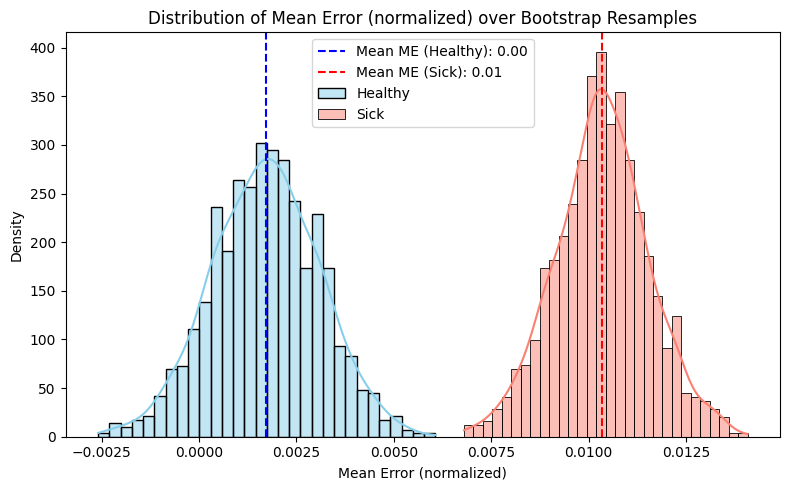

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# Mann–Whitney U test
stat, p_value = mannwhitneyu(mean_errors_h_norm, mean_errors_s_norm, alternative='two-sided')
print(f"Mann–Whitney U test statistic: {stat:.2f}, p-value: {p_value:.4f}")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(mean_errors_h_norm, label="Healthy", color="skyblue", kde=True, stat="density", bins=30)
sns.histplot(mean_errors_s_norm, label="Sick", color="salmon", kde=True, stat="density", bins=30)

# Mean lines
plt.axvline(np.mean(mean_errors_h_norm), color="blue", linestyle="--", 
            label=f"Mean ME (Healthy): {np.mean(mean_errors_h_norm):.2f}")
plt.axvline(np.mean(mean_errors_s_norm), color="red", linestyle="--", 
            label=f"Mean ME (Sick): {np.mean(mean_errors_s_norm):.2f}")

# Labels in English
plt.title("Distribution of Mean Error (normalized) over Bootstrap Resamples")
plt.xlabel("Mean Error (normalized)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


In [175]:
mean_errors_h_norm = np.array(mean_errors_h_norm)
mean_errors_s_norm = np.array(mean_errors_s_norm)
mean_h = np.mean(mean_errors_h_norm)
std_h = np.std(mean_errors_h_norm)
mean_s = np.mean(mean_errors_s_norm)
std_s = np.std(mean_errors_s_norm)
print(f"Healthy Mean Error: {mean_h:.3f} ± {std_h:.3f}")
print(f"Sick Mean Error: {mean_s:.3f} ± {std_s:.3f}")

Healthy Mean Error: 0.002 ± 0.001
Sick Mean Error: 0.010 ± 0.001


Inception Net

In [145]:
model_inc = load_model(r'C:\Users\Utente\Desktop\Chiara\Codici\Cose nuove\Nuovi\Final_mean\Codes\Trained Models\Inception_ResNet_v1.keras')

In [146]:
#y_true_healthy = y_windows_test.flatten()
y_pred_healthy_inc = model_inc.predict(X_windows_test).flatten()

#y_true_sick = y_windows_test_sick.flatten()
y_pred_sick_inc = model_inc.predict(X_windows_test_sick).flatten()

120/120 [==============================] - 9s 74ms/step


In [147]:
metrics_all_inc, metrics_healthy_inc, metrics_sick_inc, mean_errors_h_norm_inc, mean_errors_s_norm_inc = bootstrap_metrics_matched(
    y_true_healthy, y_pred_healthy_inc,
    y_true_sick, y_pred_sick_inc,
    n_samples=50,
    n_bootstrap=1000,
    n_bins=20,
    random_state=42
)

ci_all_inc = compute_confidence_intervals(metrics_all_inc)
ci_h_inc = compute_confidence_intervals(metrics_healthy_inc)
ci_s_inc = compute_confidence_intervals(metrics_sick_inc)

print("✅ Confidence Intervals (ALL):", ci_all_inc)
print("🟩 Confidence Intervals (HEALTHY):", ci_h_inc)
print("🟥 Confidence Intervals (SICK):", ci_s_inc)

✅ Confidence Intervals (ALL): {'MAE_norm': (0.34860827365823843, 0.34812398400849, 0.34912613379105234), 'MSE_norm': (0.18005361066844766, 0.17923986295222188, 0.1809447313396506), 'MAE_denorm': (10.981160487821072, 10.965905190376564, 10.997473038886845), 'MSE_denorm': (178.65819085071155, 177.85075051811856, 179.5424046713313), 'MAE_denorm_div7': (1.5687372125458674, 1.566557884339509, 1.5710675769838351), 'MSE_denorm_div7': (25.522598692958788, 25.40725007401694, 25.648914953047328), 'R2': (-0.0011389511911414376, -0.001365992091988083, -0.0009091231042283598), 'P_value_R2': (1.0, 1.0, 1.0), 'Pearson': (0.03887934156563377, 0.028514330987378246, 0.04940183006326247), 'Spearman': (0.03592888288246692, 0.026320473240082205, 0.046113244222055094), 'P_value_pearson': (0.008306564291832018, 0.0003175188275618705, 0.037767158606623615), 'P_value_spearman': (0.014053053767258735, 0.0007776846454942325, 0.055176297192674056), 'Slope': (0.0003812113014832258, 0.0002804730876669463, 0.0004849

In [148]:
print("Healthy subjects:")
for metrica, (mean, lower, upper) in ci_h_inc.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")

print("\nSick subjects:")
for metrica, (mean, lower, upper) in ci_s_inc.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")


Healthy subjects:
MAE_norm: 0.347 (IC 95%: 0.347 - 0.348)
MSE_norm: 0.178 (IC 95%: 0.178 - 0.178)
MAE_denorm: 10.936 (IC 95%: 10.925 - 10.948)
MSE_denorm: 176.617 (IC 95%: 176.415 - 176.804)
MAE_denorm_div7: 1.562 (IC 95%: 1.561 - 1.564)
MSE_denorm_div7: 25.231 (IC 95%: 25.202 - 25.258)
R2: -0.002 (IC 95%: -0.002 - -0.002)
P_value_R2: 1.000 (IC 95%: 1.000 - 1.000)
Pearson: 0.018 (IC 95%: 0.009 - 0.025)
Spearman: 0.016 (IC 95%: 0.006 - 0.026)
P_value_pearson: 0.377 (IC 95%: 0.191 - 0.639)
P_value_spearman: 0.413 (IC 95%: 0.177 - 0.749)
Slope: 0.000 (IC 95%: 0.000 - 0.000)

Sick subjects:
MAE_norm: 0.350 (IC 95%: 0.349 - 0.351)
MSE_norm: 0.182 (IC 95%: 0.181 - 0.184)
MAE_denorm: 11.026 (IC 95%: 10.997 - 11.057)
MSE_denorm: 180.699 (IC 95%: 179.124 - 182.476)
MAE_denorm_div7: 1.575 (IC 95%: 1.571 - 1.580)
MSE_denorm_div7: 25.814 (IC 95%: 25.589 - 26.068)
R2: -0.001 (IC 95%: -0.001 - -0.000)
P_value_R2: 0.999 (IC 95%: 1.000 - 1.000)
Pearson: 0.060 (IC 95%: 0.043 - 0.081)
Spearman: 0.055 (I

Mann–Whitney U test statistic: 997310.00, p-value: 0.0000


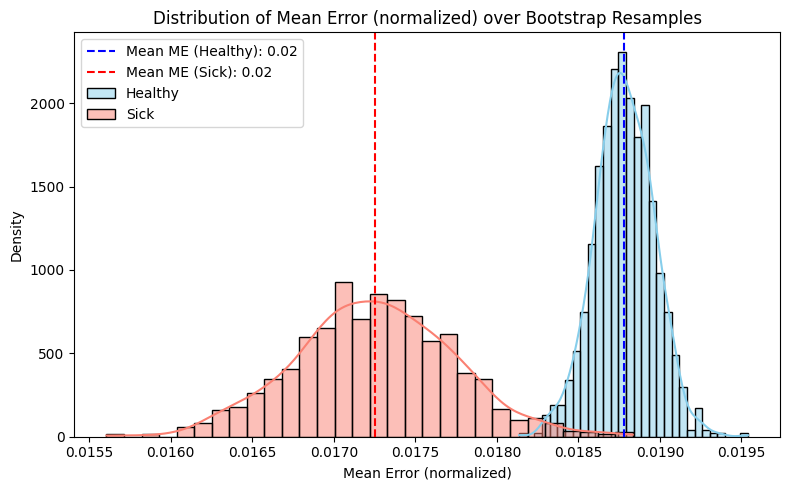

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# Mann–Whitney U test
stat, p_value = mannwhitneyu(mean_errors_h_norm_inc, mean_errors_s_norm_inc, alternative='two-sided')
print(f"Mann–Whitney U test statistic: {stat:.2f}, p-value: {p_value:.4f}")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(mean_errors_h_norm_inc, label="Healthy", color="skyblue", kde=True, stat="density", bins=30)
sns.histplot(mean_errors_s_norm_inc, label="Sick", color="salmon", kde=True, stat="density", bins=30)

# Mean lines
plt.axvline(np.mean(mean_errors_h_norm_inc), color="blue", linestyle="--", 
            label=f"Mean ME (Healthy): {np.mean(mean_errors_h_norm_inc):.2f}")
plt.axvline(np.mean(mean_errors_s_norm_inc), color="red", linestyle="--", 
            label=f"Mean ME (Sick): {np.mean(mean_errors_s_norm_inc):.2f}")

# Labels in English
plt.title("Distribution of Mean Error (normalized) over Bootstrap Resamples")
plt.xlabel("Mean Error (normalized)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [176]:
mean_errors_h_norm_inc = np.array(mean_errors_h_norm_inc)
mean_errors_s_norm_inc = np.array(mean_errors_s_norm_inc)
mean_h = np.mean(mean_errors_h_norm_inc)
std_h = np.std(mean_errors_h_norm_inc)
mean_s = np.mean(mean_errors_s_norm_inc)
std_s = np.std(mean_errors_s_norm_inc)
print(f"Healthy Mean Error: {mean_h:.3f} ± {std_h:.3f}")
print(f"Sick Mean Error: {mean_s:.3f} ± {std_s:.3f}")

Healthy Mean Error: 0.019 ± 0.000
Sick Mean Error: 0.017 ± 0.000


ResNet with activity state

In [150]:
model_qa = load_model(r'C:\Users\Utente\Desktop\Chiara\Codici\Cose nuove\Nuovi\Final_mean\Codes\Trained Models\model_with_QA_mean.keras')

In [151]:
train_q_a = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\DockerImage\softmax_predictions_train_non_norm.pkl")
test_q_a = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\DockerImage\softmax_predictions_test_non_norm.pkl")
test_sick_q_a = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\DockerImage\softmax_predictions_test_sick_non_norm.pkl")

In [152]:
train = pd.concat([train, train_q_a], axis=1)
test = pd.concat([test_healthy, test_q_a], axis=1)
test_sick = pd.concat([test_sick, test_sick_q_a], axis=1)

In [153]:
X_windows_train, y_windows_train= WindowSignals(train['signals'], train['y'])
X_windows_test, y_windows_test = WindowSignals(test['signals'], test['y'])
X_windows_test_sick, y_windows_test_sick = WindowSignals(test_sick['signals'], test_sick['y'])

X_windows_train_qa, y_windows_train= WindowSignals(train['softmax_prediction_list'], train['y'])
X_windows_test_qa, y_windows_test_qa = WindowSignals(test['softmax_prediction_list'], test['y'])
X_windows_test_sick_qa, y_windows_test_sick_qa = WindowSignals(test_sick['softmax_prediction_list'], test_sick['y'])

In [154]:
y_windows_test_scaled = scaler.transform(y_windows_test.reshape(-1, 1))
y_windows_test_sick_scaled = scaler.transform(y_windows_test_sick.reshape(-1, 1))
y_windows_test = y_windows_test_scaled
y_windows_test_sick = y_windows_test_sick_scaled

In [155]:
X_test = np.stack([X_windows_test, X_windows_test_qa], axis=-1)  # (batch_size, timesteps, 2)
X_test_sick = np.stack([X_windows_test_sick, X_windows_test_sick_qa], axis=-1)  # (batch_size, timesteps, 2)

In [156]:
X_windows_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
X_windows_test_sick = tf.convert_to_tensor(X_test_sick, dtype=tf.float32)

In [157]:
y_windows_test = tf.convert_to_tensor(y_windows_test, dtype=tf.float32)
y_windows_test_sick = tf.convert_to_tensor(y_windows_test_sick, dtype=tf.float32)

In [158]:
#y_true_healthy = y_windows_test.flatten()
y_pred_healthy_qa = model_qa.predict(X_windows_test).flatten()

#y_true_sick = y_windows_test_sick.flatten()
y_pred_sick_qa = model_qa.predict(X_windows_test_sick).flatten()

120/120 [==============================] - 5s 45ms/step


In [159]:
metrics_all_qa, metrics_healthy_qa, metrics_sick_qa, mean_errors_h_norm_qa, mean_errors_s_norm_qa = bootstrap_metrics_matched(
    y_true_healthy, y_pred_healthy_qa,
    y_true_sick, y_pred_sick_qa,
    n_samples=50,
    n_bootstrap=1000,
    n_bins=20,
    random_state=42
)

ci_all_qa = compute_confidence_intervals(metrics_all_qa)
ci_h_qa = compute_confidence_intervals(metrics_healthy_qa)
ci_s_qa = compute_confidence_intervals(metrics_sick_qa)

print("✅ Confidence Intervals (ALL):", ci_all_qa)
print("🟩 Confidence Intervals (HEALTHY):", ci_h_qa)
print("🟥 Confidence Intervals (SICK):", ci_s_qa)

✅ Confidence Intervals (ALL): {'MAE_norm': (0.29191527769276976, 0.29058588219207904, 0.29320768589226526), 'MSE_norm': (0.1312209133194927, 0.1298199845577857, 0.13264335127132615), 'MAE_denorm': (9.195331077581434, 9.153455125108731, 9.236041964564722), 'MSE_denorm': (130.20394679684802, 128.81387412011617, 131.61535905028757), 'MAE_denorm_div7': (1.3136187253687763, 1.3076364464441044, 1.319434566366389), 'MSE_denorm_div7': (18.600563828121143, 18.40198201715945, 18.802194150041082), 'R2': (0.27038276305993586, 0.26381302954400093, 0.2766989133069431), 'P_value_R2': (1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16), 'Pearson': (0.532937279350111, 0.5254174931592664, 0.5401976955487067), 'Spearman': (0.5350532385435935, 0.5285958584756526, 0.5419204866994275), 'P_value_pearson': (0.0, 0.0, 0.0), 'P_value_spearman': (0.0, 0.0, 0.0), 'Slope': (0.2218018207416189, 0.2179597506863763, 0.2257638922790249)}
🟩 Confidence Intervals (HEALTHY): {'MAE_norm': (0.2885568406

In [160]:
print("Healthy subjects:")
for metrica, (mean, lower, upper) in ci_h_qa.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")

print("\nSick subjects:")
for metrica, (mean, lower, upper) in ci_s_qa.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")


Healthy subjects:
MAE_norm: 0.289 (IC 95%: 0.287 - 0.290)
MSE_norm: 0.127 (IC 95%: 0.126 - 0.128)
MAE_denorm: 9.090 (IC 95%: 9.034 - 9.146)
MSE_denorm: 125.819 (IC 95%: 124.921 - 126.656)
MAE_denorm_div7: 1.299 (IC 95%: 1.291 - 1.307)
MSE_denorm_div7: 17.974 (IC 95%: 17.846 - 18.094)
R2: 0.286 (IC 95%: 0.282 - 0.291)
P_value_R2: 0.000 (IC 95%: 0.000 - 0.000)
Pearson: 0.554 (IC 95%: 0.548 - 0.561)
Spearman: 0.556 (IC 95%: 0.549 - 0.563)
P_value_pearson: 0.000 (IC 95%: 0.000 - 0.000)
P_value_spearman: 0.000 (IC 95%: 0.000 - 0.000)
Slope: 0.227 (IC 95%: 0.225 - 0.230)

Sick subjects:
MAE_norm: 0.295 (IC 95%: 0.293 - 0.297)
MSE_norm: 0.136 (IC 95%: 0.133 - 0.138)
MAE_denorm: 9.301 (IC 95%: 9.240 - 9.364)
MSE_denorm: 134.589 (IC 95%: 131.942 - 137.135)
MAE_denorm_div7: 1.329 (IC 95%: 1.320 - 1.338)
MSE_denorm_div7: 19.227 (IC 95%: 18.849 - 19.591)
R2: 0.255 (IC 95%: 0.243 - 0.267)
P_value_R2: 0.000 (IC 95%: 0.000 - 0.000)
Pearson: 0.513 (IC 95%: 0.500 - 0.527)
Spearman: 0.515 (IC 95%: 0.504

Mann–Whitney U test statistic: 2.00, p-value: 0.0000


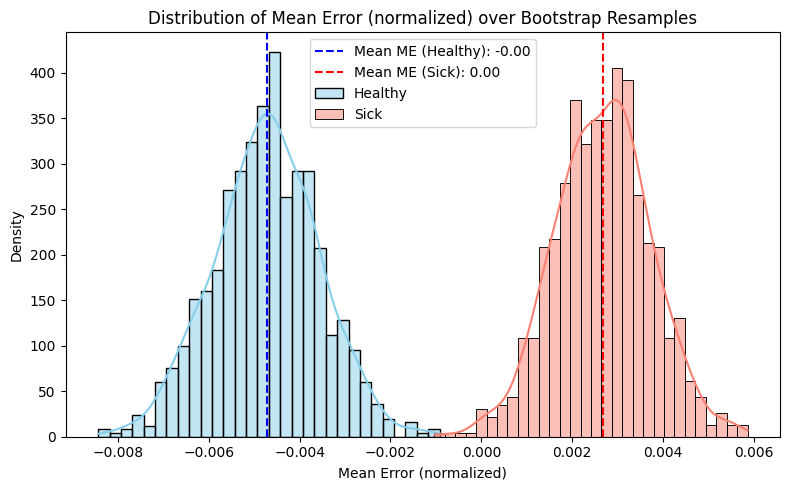

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# Mann–Whitney U test
stat, p_value = mannwhitneyu(mean_errors_h_norm_qa, mean_errors_s_norm_qa, alternative='two-sided')
print(f"Mann–Whitney U test statistic: {stat:.2f}, p-value: {p_value:.4f}")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(mean_errors_h_norm_qa, label="Healthy", color="skyblue", kde=True, stat="density", bins=30)
sns.histplot(mean_errors_s_norm_qa, label="Sick", color="salmon", kde=True, stat="density", bins=30)

# Mean lines
plt.axvline(np.mean(mean_errors_h_norm_qa), color="blue", linestyle="--", 
            label=f"Mean ME (Healthy): {np.mean(mean_errors_h_norm_qa):.2f}")
plt.axvline(np.mean(mean_errors_s_norm_qa), color="red", linestyle="--", 
            label=f"Mean ME (Sick): {np.mean(mean_errors_s_norm_qa):.2f}")

# Labels in English
plt.title("Distribution of Mean Error (normalized) over Bootstrap Resamples")
plt.xlabel("Mean Error (normalized)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [177]:
mean_errors_h_norm_qa = np.array(mean_errors_h_norm_qa)
mean_errors_s_norm_qa = np.array(mean_errors_s_norm_qa)
mean_h = np.mean(mean_errors_h_norm_qa)
std_h = np.std(mean_errors_h_norm_qa)
mean_s = np.mean(mean_errors_s_norm_qa)
std_s = np.std(mean_errors_s_norm_qa)
print(f"Healthy Mean Error: {mean_h:.3f} ± {std_h:.3f}")
print(f"Sick Mean Error: {mean_s:.3f} ± {std_s:.3f}")

Healthy Mean Error: -0.005 ± 0.001
Sick Mean Error: 0.003 ± 0.001


ResNet with FMP

In [162]:
model_fmp = load_model(r'C:\Users\Utente\Desktop\Chiara\Codici\Cose nuove\Nuovi\Final_mean\Codes\Trained Models\model_FMP_mean.keras')

In [163]:
train = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\SUBSET\df_mean_train_FMP.pkl")
train['FHR'] = train['FHR'].apply(lambda x: x[0] if isinstance(x, list) else x)
train['FMP'] = train['FMP'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [164]:
test = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\SUBSET\df_mean_test_FMP.pkl")
test['FHR'] = test['FHR'].apply(lambda x: x[0] if isinstance(x, list) else x)
test['FMP'] = test['FMP'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [165]:
test_sick = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\SUBSET\df_mean_malati_FMP.pkl")
test_sick['FHR'] = test_sick['FHR'].apply(lambda x: x[0] if isinstance(x, list) else x)
test_sick['FMP'] = test_sick['FMP'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [166]:
X_windows_train_FHR, y_windows_train= WindowSignals(train['FHR'], train['y'])
X_windows_test_FHR, y_windows_test = WindowSignals(test['FHR'], test['y'])
X_windows_test_sick_FHR, y_windows_test_sick = WindowSignals(test_sick['FHR'], test_sick['y'])

In [167]:
X_windows_train_FMP, y_windows_train= WindowSignals(train['FMP'], train['y'])
X_windows_test_FMP, y_windows_test = WindowSignals(test['FMP'], test['y'])
X_windows_test_sick_FMP, y_windows_test_sick = WindowSignals(test_sick['FHR'], test_sick['y'])

In [168]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(y_windows_train.reshape(-1, 1))

y_windows_train_scaled = scaler.transform(y_windows_train.reshape(-1, 1))
y_windows_test_scaled = scaler.transform(y_windows_test.reshape(-1, 1))
y_windows_test_sick_scaled = scaler.transform(y_windows_test_sick.reshape(-1, 1))
y_windows_train = y_windows_train_scaled
y_windows_test = y_windows_test_scaled
y_windows_test_sick = y_windows_test_sick_scaled

In [169]:
X_test = np.stack([X_windows_test_FHR, X_windows_test_FMP], axis=-1)
X_test_sick = np.stack([X_windows_test_sick_FHR, X_windows_test_sick_FMP], axis=-1) 
X_windows_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
X_windows_test_sick = tf.convert_to_tensor(X_test_sick, dtype=tf.float32)

In [170]:
y_windows_test = tf.convert_to_tensor(y_windows_test, dtype=tf.float32)
y_windows_test_sick = tf.convert_to_tensor(y_windows_test_sick, dtype=tf.float32)

In [171]:
#y_true_healthy = y_windows_test.flatten()
y_pred_healthy_fmp = model_fmp.predict(X_windows_test).flatten()

#y_true_sick = y_windows_test_sick.flatten()
y_pred_sick_fmp = model_fmp.predict(X_windows_test_sick).flatten()

120/120 [==============================] - 5s 45ms/step


In [172]:
metrics_all_fmp, metrics_healthy_fmp, metrics_sick_fmp, mean_errors_h_norm_fmp, mean_errors_s_norm_fmp = bootstrap_metrics_matched(
    y_true_healthy, y_pred_healthy_fmp,
    y_true_sick, y_pred_sick_fmp,
    n_samples=50,
    n_bootstrap=1000,
    n_bins=20,
    random_state=42
)

ci_all_fmp = compute_confidence_intervals(metrics_all_fmp)
ci_h_fmp = compute_confidence_intervals(metrics_healthy_fmp)
ci_s_fmp = compute_confidence_intervals(metrics_sick_fmp)

print("✅ Confidence Intervals (ALL):", ci_all_fmp)
print("🟩 Confidence Intervals (HEALTHY):", ci_h_fmp)
print("🟥 Confidence Intervals (SICK):", ci_s_fmp)

✅ Confidence Intervals (ALL): {'MAE_norm': (0.36436616011740647, 0.36177729765181704, 0.3667103780927463), 'MSE_norm': (0.22715724303998094, 0.21886411728755598, 0.23541376233655376), 'MAE_denorm': (11.477534240141969, 11.39598506612713, 11.551377082284269), 'MSE_denorm': (225.39678154026905, 217.167924792078, 233.58931417855845), 'MAE_denorm_div7': (1.6396477485917103, 1.6279978665895898, 1.6501967260406096), 'MSE_denorm_div7': (32.199540220038436, 31.023989256011145, 33.36990202550835), 'R2': (-0.2630518388666402, -0.30925833260183483, -0.2187586163023757), 'P_value_R2': (1.0, 1.0, 1.0), 'Pearson': (0.15679181988908808, 0.13920011842679322, 0.17507363508178003), 'Spearman': (0.26755759502805077, 0.2579613309147564, 0.2787844129955484), 'P_value_pearson': (1.7336916814767295e-24, 8.433369046851541e-38, 2.225587502238206e-24), 'P_value_spearman': (9.91339469300792e-81, 2.3623973413164352e-95, 1.9311021681255935e-81), 'Slope': (0.10611152891025918, 0.09654981072478103, 0.115855118766392

In [173]:
print("Healthy subjects:")
for metrica, (mean, lower, upper) in ci_h_fmp.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")

print("\nSick subjects:")
for metrica, (mean, lower, upper) in ci_s_fmp.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")

Healthy subjects:
MAE_norm: 0.286 (IC 95%: 0.284 - 0.288)
MSE_norm: 0.126 (IC 95%: 0.126 - 0.127)
MAE_denorm: 9.007 (IC 95%: 8.949 - 9.061)
MSE_denorm: 125.457 (IC 95%: 124.531 - 126.313)
MAE_denorm_div7: 1.287 (IC 95%: 1.278 - 1.294)
MSE_denorm_div7: 17.922 (IC 95%: 17.790 - 18.045)
R2: 0.288 (IC 95%: 0.284 - 0.294)
P_value_R2: 0.000 (IC 95%: 0.000 - 0.000)
Pearson: 0.560 (IC 95%: 0.554 - 0.567)
Spearman: 0.556 (IC 95%: 0.549 - 0.564)
P_value_pearson: 0.000 (IC 95%: 0.000 - 0.000)
P_value_spearman: 0.000 (IC 95%: 0.000 - 0.000)
Slope: 0.229 (IC 95%: 0.227 - 0.232)

Sick subjects:
MAE_norm: 0.443 (IC 95%: 0.438 - 0.447)
MSE_norm: 0.328 (IC 95%: 0.312 - 0.345)
MAE_denorm: 13.948 (IC 95%: 13.797 - 14.091)
MSE_denorm: 325.337 (IC 95%: 309.244 - 341.877)
MAE_denorm_div7: 1.993 (IC 95%: 1.971 - 2.013)
MSE_denorm_div7: 46.477 (IC 95%: 44.178 - 48.840)
R2: -0.801 (IC 95%: -0.894 - -0.714)
P_value_R2: 1.000 (IC 95%: 1.000 - 1.000)
Pearson: -0.016 (IC 95%: -0.038 - 0.007)
Spearman: 0.034 (IC 95

Mann–Whitney U test statistic: 1000000.00, p-value: 0.0000


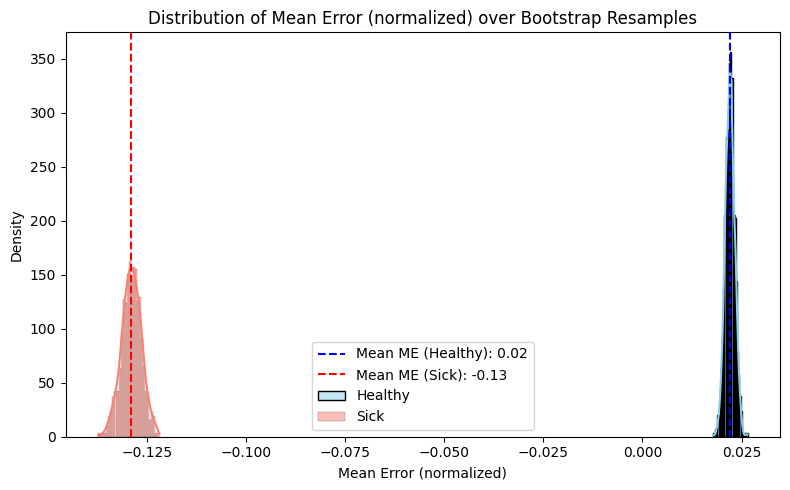

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# Mann–Whitney U test
stat, p_value = mannwhitneyu(mean_errors_h_norm_fmp, mean_errors_s_norm_fmp, alternative='two-sided')
print(f"Mann–Whitney U test statistic: {stat:.2f}, p-value: {p_value:.4f}")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(mean_errors_h_norm_fmp, label="Healthy", color="skyblue", kde=True, stat="density", bins=30)
sns.histplot(mean_errors_s_norm_fmp, label="Sick", color="salmon", kde=True, stat="density", bins=30)

# Mean lines
plt.axvline(np.mean(mean_errors_h_norm_fmp), color="blue", linestyle="--", 
            label=f"Mean ME (Healthy): {np.mean(mean_errors_h_norm_fmp):.2f}")
plt.axvline(np.mean(mean_errors_s_norm_fmp), color="red", linestyle="--", 
            label=f"Mean ME (Sick): {np.mean(mean_errors_s_norm_fmp):.2f}")

# Labels in English
plt.title("Distribution of Mean Error (normalized) over Bootstrap Resamples")
plt.xlabel("Mean Error (normalized)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [178]:
mean_errors_h_norm_fmp = np.array(mean_errors_h_norm_fmp)
mean_errors_s_norm_fmp = np.array(mean_errors_s_norm_fmp)
mean_h = np.mean(mean_errors_h_norm_fmp)
std_h = np.std(mean_errors_h_norm_fmp)
mean_s = np.mean(mean_errors_s_norm_fmp)
std_s = np.std(mean_errors_s_norm_fmp)
print(f"Healthy Mean Error: {mean_h:.3f} ± {std_h:.3f}")
print(f"Sick Mean Error: {mean_s:.3f} ± {std_s:.3f}")

Healthy Mean Error: 0.022 ± 0.001
Sick Mean Error: -0.129 ± 0.003
